## Initializing the notebook
These first few cells must be run first every time you are starting this program for the first time. The first cell imports a bunch of useful functions, and sets up some pretty plots. The second cell starts up a GUI that establishes communications with the lab equipment, sets up the experiment, and runs it.

**Note** This notebook is running a Python kernel, which is a dedicated computer process that just runs this stuff. At any time, you can interrupt an operation by going up to the "Kernel" menu and clicking Interrupt, or you can completely stop it and restart it by choosing Restart.

If you want to switch to a different program that uses any of the lab equipment that this program also uses, you will need to first restart the kernel, thus releasing ownership of those devices (there are other ways to do this as well, but this is the easiest).

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../../../pyscan-master/')

import pyscan as ps
import matplotlib.pyplot as plt
import numpy as np
import utility as ut
from time import sleep
from datetime import date, datetime
from pathlib import Path
from cwsweep_gui import *
from cwsweep_scripts import *
if 'devices' not in globals():
    devices = ps.ItemAttribute()
    sig = ps.ItemAttribute()
    sweep = {}

plt.rc('lines', lw=2)
plotfont = {'family': 'serif', 'size': 16}
plt.rc('font', **plotfont)
plt.rc('mathtext', fontset='cm')

wait = 0.05

In [2]:
controls, parameters = cwsweep_gui(sig, devices, sweep)
controls

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [3]:
devices.scope.trigger_source

('CH1', 'EDGE')

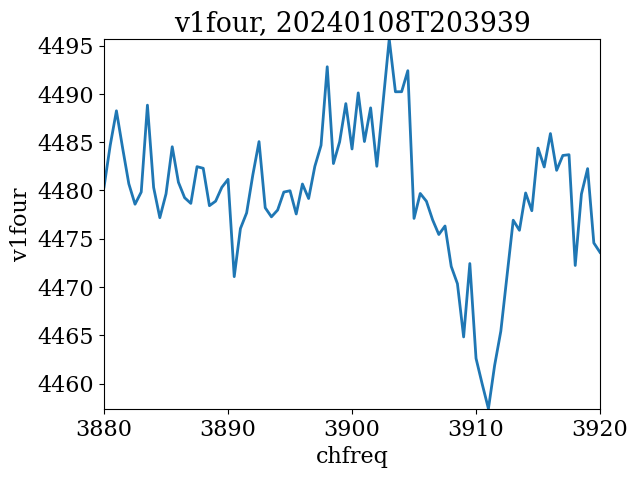

In [35]:
ps.live_plot1D(sweep['expt'], x_name=parameters['y_name'], data_name='v1four', transpose=1)

In [36]:
sweep['expt'].chfreq[sweep['expt'].v1four.argmin()]

3911.0

In [27]:
def chfreq(freq):
    devices.synth.c1_freq = freq+1
    devices.synth.c2_freq = freq

In [32]:
chfreq(4400)

In [33]:
def read_sig(ave, n=40, sltime=0, reps=1):
    devices.scope.average = 1
    sleep(0.1)
    devices.scope.average = ave
    sleep(0.1)
    sig = devices.scope.read_vxy(sltime=sltime, reps=reps)
    out = sig.fourier[:, n]
    return out

In [70]:
freqs = np.arange(parameters['freq_start'], parameters['freq_end'], parameters['freq_step'])
sigs = np.zeros((len(freqs), 3))
for i, f in enumerate(freqs):
    chfreq(f)
    sleep(0.1)
    sigs[i] = read_sig(parameters['ave'])

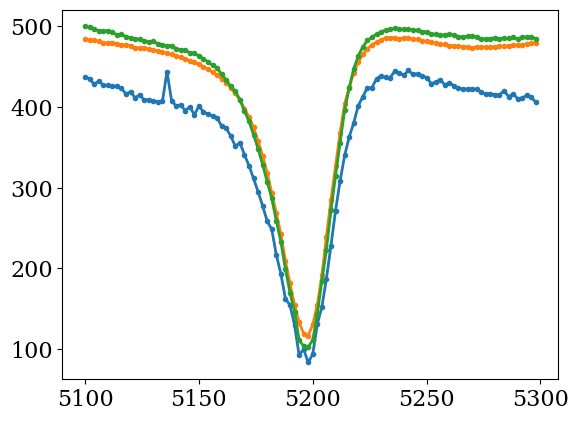

In [71]:
plt.plot(freqs, sigs, '.-');

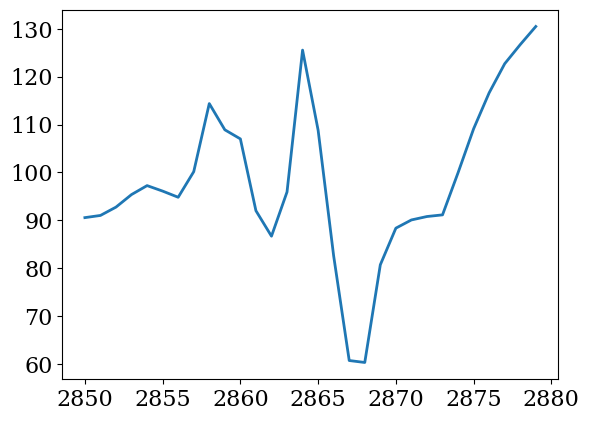

In [17]:
plt.plot(freqs, [np.max(sig) for sig in sigs])

In [29]:
fmin = freqs[sigs[:,1].argmin()]
print(fmin)
chfreq(fmin)

2869.5


[array([ 652.94896512, -510.18863283,    9.42101251, 4208.61042989]),
 446.72591459555855]

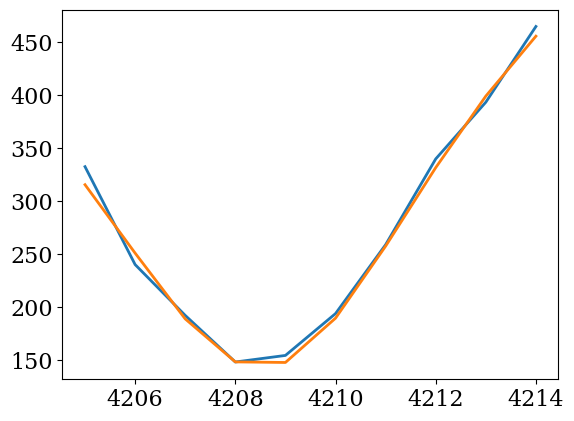

In [58]:
ut.plot_lor_fit(np.array([freqs, sigs]))

In [59]:
chfreq(4208.6)

In [68]:
devices.psu.v2 = 0.2

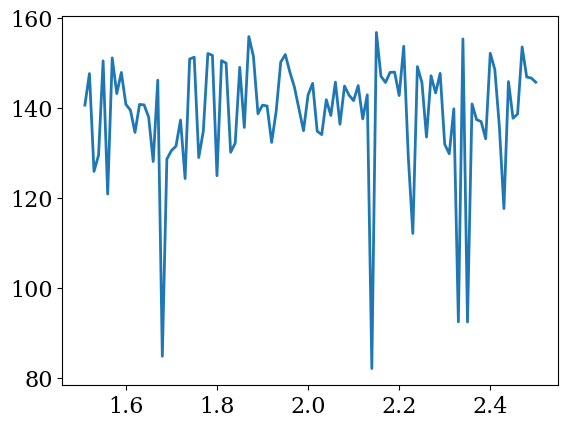

In [65]:
vs = np.arange(2.5, 1.5, -0.01)
vsigs1 = np.zeros(len(vs))
for i, v in enumerate(vs):
    devices.psu.v2 = v
    sleep(1)
    vsigs1[i] = read_sig(256, sltime=0.1, reps=20)
plt.plot(vs, vsigs1)

# Measure magnetic field

In [70]:
def read_field(ave, sltime=0, reps=1):
    devices.scope.average = 1
    sleep(0.1)
    devices.scope.average = ave
    sleep(sltime)
    sig = devices.scope.read_vxy(sltime=sltime, reps=reps)
    return np.mean(sig.volt1)

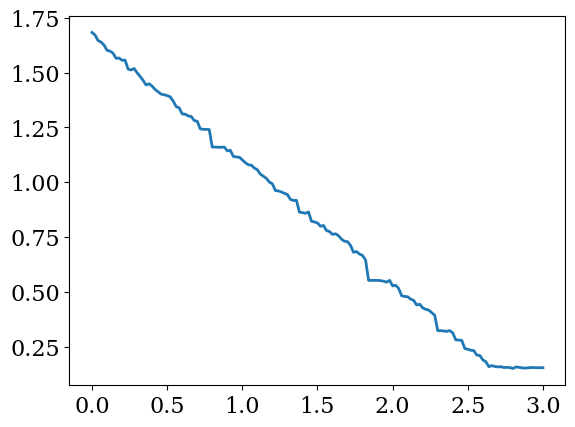

In [88]:
vs = np.arange(0, 3.01, 0.02)[::-1]
vsigs1 = np.zeros(len(vs))
tdiv = 10e-6
devices.scope.trigger_delay = 10e-5
devices.scope.time_division = tdiv
devices.scope.read_screen()
ave = 256
sltime = 0.5#ave*tdiv
for i, v in enumerate(vs):
    devices.psu.v2 = v
    sleep(sltime)
    vsigs1[i] = read_field(256)
plt.plot(vs, vsigs1)

poly1d([-0.5682931 ,  1.66685528])

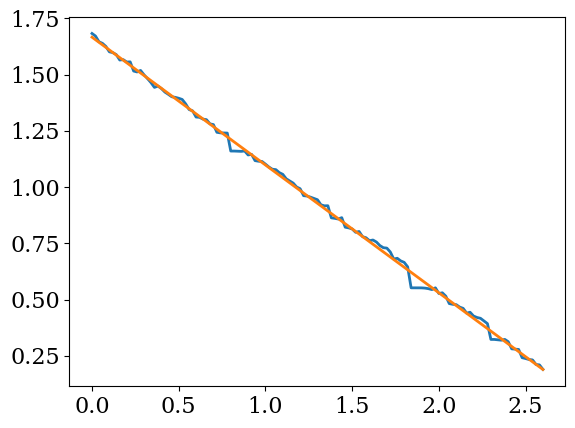

In [91]:
fit = np.poly1d(np.polyfit(vs[20:], vsigs1[20:], 1))
plt.plot(vs[20:], vsigs1[20:])
plt.plot(vs[20:], fit(vs[20:]))
fit

In [28]:
def freqscope():
    ch1 = devices.scope.measure_freq_sweep(parameters, init=False)
    ch2 = devices.scope.measure_freq_sweep(parameters, channel=2, init=False)
    sig = v_to_s(ch1, ch2)
    return sig.freq, sig.x

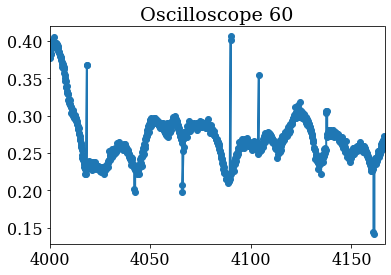

In [15]:
ps.oscilloscope(freqscope, histo_range=1, dt=0.01)

[ 3.23473632e-01  9.36596415e-02  9.20339700e+00  6.05316570e+03
  1.33881499e-01 -2.35508856e+02  6.19437457e+03 -4.62276248e-04]
Q1 is 657.7099414050041 and Q2 is -26.302087693046243


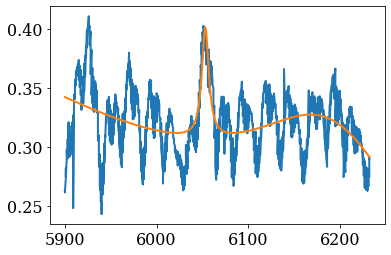

In [26]:
tfit = ut.PlotDoublelor_fit_range(np.array([sig.freq, sig.x]), sig.freq[0], sig.freq[-1])
print(tfit)
print(f'Q1 is {tfit[3]/tfit[2]} and Q2 is {tfit[6]/tfit[5]}')

[array([-3.19956457e-01, -6.73281694e-02,  6.83460003e+00,  5.93442865e+03]),
 868.2920177201484]

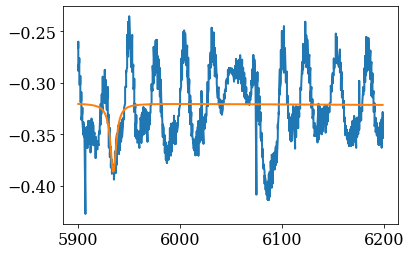

In [30]:
ut.plot_lor_fit(np.array([sig.freq, -sig.x]), full=1)

In [14]:
?ut.plot_lor_fit

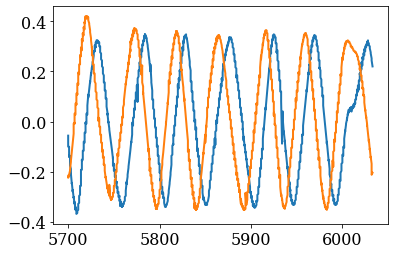

In [28]:
ch1 = devices.scope.measure_freq_sweep(parameters)
ch2 = devices.scope.measure_freq_sweep(parameters, channel=2)
plt.plot(ch1[0], ch1[1], ch2[0], ch2[1]);
# sigon = v_to_s(ch1, ch2)
# plt.plot(sigon.freq, sigon.x);

In [81]:
times = []
Qs = []
Qs2 = []
fs = []
start = datetime.now().timestamp()

In [82]:
def read_Q():
    time = datetime.now().timestamp()
    dt = (time-start)/60
    ch1 = devices.scope.measure_freq_sweep(parameters, init=False)
    ch2 = devices.scope.measure_freq_sweep(parameters, channel=2, init=False)
    sig = v_to_s(ch1, ch2)
    guess = [.02, -.03, 20, 3512]
#     fit = ut.lor_fit(np.array([sig.freq, sig.q]), guess)[0]
    fitsig = np.array([sig.freq, -sig.x])
    try:
        fit = ut.lor_fit(fitsig, guess, full=0)[0]
    except ValueError:
        fit = ut.lor_fit(fitsig, guess, full=0)[0]
    Q = np.abs(fit[-1]/fit[-2]) if fit[-2] != 0 else Qs[-1]
    f = fit[-1]
    times.append(time)
    fs.append(f)
    Qs.append(Q)
#     save_temp(times, temps)
    
#     return [[time, time], [temp, setpoint]]
    return dt, [Q, f]

In [83]:
def read_2Q():
    time = datetime.now().timestamp()
    dt = (time-start)/60
    ch1 = devices.scope.measure_freq_sweep(parameters, init=False)
    ch2 = devices.scope.measure_freq_sweep(parameters, channel=2, init=False)
    sig = v_to_s(ch1, ch2)
    guess = [.02, -.01, 10, 4000]
    try:
        fit = ut.Doublelor_fit_range(np.array([sig.freq, sig.x]), sig.freq[0], sig.freq[-1])[0]
    except ValueError:
        fit = ut.Doublelor_fit_range(np.array([sig.freq, sig.x]), sig.freq[0], sig.freq[-1])[0]
    Q1 = np.abs(fit[3]/fit[2])
    Q2 = np.abs(fit[6]/fit[5])
    times.append(time)
    Qs.append(Q1)
    Qs2.append(Q2)
#     save_temp(times, temps)
    
#     return [[time, time], [temp, setpoint]]
    return dt, Q1#, Q2

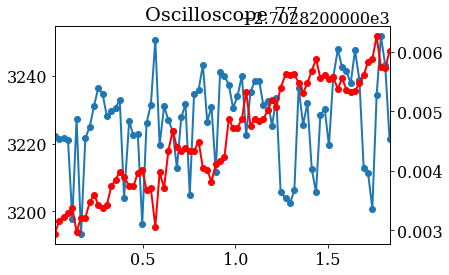

In [84]:
ps.oscilloscope(read_Q, np.inf, 0.1, numy=2)

## Measure and Save
Run this set of cells to set up, measure, and save a frequency sweep

In [7]:
def measure_freq_sweep(expt):
     
    runinfo = expt.runinfo
    devices = expt.devices
    
    if runinfo.initialize:
        initialize_freq_sweep(runinfo.params, devices)
        sleep(2)
    
    d = ps.ItemAttribute()
    
    d.freq, d.volt1 = devices.scope.measure_freq_sweep(runinfo.params, channel=1, init=False)
    _, d.volt2 = devices.scope.measure_freq_sweep(runinfo.params, channel=2, init=False)
    d.x = np.sqrt(d.volt1**2 + d.volt2**2)
    d.p = np.arccos((d.volt1**2 - d.volt2**2) / (d.volt1**2 + d.volt2**2)) / 2
    d.fit = ut.lor_fit(np.array([d.freq, d.x]))[0]
    d.Q = np.abs(d.fit[3]/d.fit[2])
    
    return d

In [8]:
runinfo = ps.RunInfo()
runinfo.loop0 = ps.RepeatScan(100, dt=0.1)

runinfo.initialize = False # Set to False to leave the FPGA and Scope settings as is

runinfo.params = parameters
runinfo.measure_function = measure_freq_sweep

# This is the only important difference
expt = ps.Sweep(runinfo, devices)#, data_dir)
# expt.start_thread()

In [9]:
expt.runinfo.items()

dict_items([('loop0', <pyscan.measurement.scans.RepeatScan object at 0x7f244875d810>), ('loop1', <pyscan.measurement.scans.PropertyScan object at 0x7f24c9b64d50>), ('loop2', <pyscan.measurement.scans.PropertyScan object at 0x7f24482e9210>), ('loop3', <pyscan.measurement.scans.PropertyScan object at 0x7f244a2de010>), ('static', {}), ('measured', []), ('measure_function', <function measure_freq_sweep at 0x7f24483220c0>), ('trigger_function', None), ('initial_pause', 0.1), ('average_d', -1), ('verbose', False), ('version', 0.2), ('initialize', False), ('params', {'scope_address': 'USB0::62700::60986::512H17303::0::INSTR', 'fpga_address': 'ASRL/dev/ttyUSB2::INSTR', 'synth_address': 'ASRL/dev/ttyACM0::INSTR', 'psu_address': 'ASRL/dev/ttyUSB0::INSTR', 'freq_start': 4100.0, 'freq_end': 4300.0, 'freq_step': 4.0, 'power': 19.0, 'ave': 64, 'scale': 0.2, 'voltage': 0.0, 'save_dir': '/home/collettlab/Research/Raw Data/Calibration/Bare', 'file_name': 'AmCu_CWSweep', 'outfile': '/home/collettlab/Res

## Stopping the sweep
When you are done with your experiments, you should turn the output off, by running the following cell. You should also turn off the power supply, if it is on.

In [1]:
devices.synth.freq_sweep_stop()

NameError: name 'devices' is not defined